# Лабораторная работа №5. Факторный анализ.
## Вариант 1.
## Булыгин Максим

Подключаем необходимые библиотеки.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns

Импортируем данные.

In [4]:
data = pd.read_csv('bank-additional-full.csv', sep=';')
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


## 1) Первичная обработка данных

Смотрим общую информацию и описательные статистики датасета.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [6]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Судя по описательным статистикам, выбросов в числовых факторах нет.

Как видим, у нас 21 фича - 10 из которых числовые, 10 категориальные и одна - отклик (y).

Проверим, есть ли пропущенные значения.

In [7]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [8]:
data[data.isna().any(axis=1)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


Пустых значений (null) в датасете нет.

In [9]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Проверим уникальные значения категориальных фич.

In [10]:
categorial = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']

In [11]:
for feat in categorial:
    print(data[feat].unique())

['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
['married' 'single' 'divorced' 'unknown']
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
['no' 'unknown' 'yes']
['no' 'yes' 'unknown']
['no' 'yes' 'unknown']
['telephone' 'cellular']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
['mon' 'tue' 'wed' 'thu' 'fri']


Видим, что в 7 категориальных факторах есть уникальное значение 'unknown', которое соответствует пропущенному значению. Возникает вопрос - что с ними делать: принимать за выбросы, или оставлять как есть?

In [12]:
data[(data['default'] == 'unknown') | (data['housing'] == 'unknown') | (data['marital'] == 'unknown') 
     | (data['education'] == 'unknown') | (data['job'] == 'unknown') | (data['loan'] == 'unknown')
    | (data['contact'] == 'unknown') | (data['month'] == 'unknown') | (data['day_of_week'] == 'unknown')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
10,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
15,54,retired,married,basic.9y,unknown,yes,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41118,34,technician,married,unknown,no,yes,no,cellular,nov,tue,...,2,999,2,failure,-1.1,94.767,-50.8,1.046,4963.6,no
41120,60,admin.,married,unknown,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,no
41122,34,technician,married,unknown,no,no,no,cellular,nov,tue,...,3,999,0,nonexistent,-1.1,94.767,-50.8,1.046,4963.6,yes
41135,54,technician,married,unknown,no,yes,no,cellular,nov,thu,...,1,999,1,failure,-1.1,94.767,-50.8,1.041,4963.6,no


Видим, что всего наблюдений, в которых есть хотя-бы одно пропущенное значение (т.е. 'unknown') всего 10700, что составляет чуть больше четверти от исходного размера датасета, поэтому исключать все эти наблюдения, из за пропущенных значений в хотя-бы одном поле - неразумно, поскольку в таком случае мы потеряем порядка четверти всех наблюдений.

Посмотрим отдельно по фичам, сколько в каждой категориальной фиче наблюдений с 'unknown'.

In [13]:
for feat in categorial:
    print(f"Фича {feat} имеет {len(data[data[feat] == 'unknown'])} полей unknown")

Фича job имеет 330 полей unknown
Фича marital имеет 80 полей unknown
Фича education имеет 1731 полей unknown
Фича default имеет 8597 полей unknown
Фича housing имеет 990 полей unknown
Фича loan имеет 990 полей unknown
Фича contact имеет 0 полей unknown
Фича month имеет 0 полей unknown
Фича day_of_week имеет 0 полей unknown


In [14]:
data.default.unique()

array(['no', 'unknown', 'yes'], dtype=object)

Видим, что категориальная переменная default имеет 8597 полей unknown - что составляет чуть меньше четверти от размера датасета, причем эта переменная - бинарная (yes/no), поэтому включение/невключение этой переменной в набор предикторов может существенно повлиять на полученный результат. В данной лабораторной работе, попробуем исключить переменную default из набора предикторов.

In [15]:
data = data.drop(columns=['default'])
data

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


Что же делать с другими категориальными фичами с пропусками?

In [16]:
data.job.unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [17]:
data.marital.unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [18]:
data.education.unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

Переменные job, marital, education имеют большое (>2) количество уникальных значений, поэтому, исключать их из рассмотрения неразумно - поэтому, удалим из исходного набора данных 330 + 80 наблюдений с пропущенным значением job, marital, а также удалим 1731 пропуск в переменной education.

In [19]:
data = data[(data.job != 'unknown') & (data.marital != 'unknown') & (data.education != 'unknown')]
data

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [20]:
data.housing.unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [21]:
data.loan.unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [22]:
print(len(data[(data.loan == 'unknown') | (data.housing == 'unknown')]))
print(len(data[(data.loan == 'unknown') & (data.housing == 'unknown')]))

946
946


А переменные loan и housing являются бинарными категориальными - пропущенных значений в каждой из них и в них суммарно - 946, что составляет 1/40 от размера датасета - поэтому, просто удалим 984 наблюдения.

In [23]:
data = data[(data.loan != 'unknown') & (data.housing != 'unknown')]
data

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [24]:
2943/41188

0.07145285034476061

Теперь имеем:

In [25]:
for feat in categorial:
    if feat != 'default':
        print(f"Фича {feat} имеет {len(data[data[feat] == 'unknown'])} полей unknown")

Фича job имеет 0 полей unknown
Фича marital имеет 0 полей unknown
Фича education имеет 0 полей unknown
Фича housing имеет 0 полей unknown
Фича loan имеет 0 полей unknown
Фича contact имеет 0 полей unknown
Фича month имеет 0 полей unknown
Фича day_of_week имеет 0 полей unknown


Мы потеряли 41188 - 38245 = 2943 наблюдения, что составляет семь сотых от размера исходного датасета - это приемлемый результат, однако мы обработали пропущенные значения, которые могут существенно повлиять на результаты random forest classifier (который будет использован далее).

Теперь, необходимо закодировать с помощью дамми-переменными категориальные переменные, расширив датасет новым набором фич, которые будут соответствовать закодированным категориальным переменным.

Создадим новый датафрейм, сначала в него войдут только числовые фичи.

In [26]:
df = data[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
           'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6


In [27]:
categorial_edited = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week']

In [28]:
for feat in categorial_edited:
    print(data[feat].unique())

['housemaid' 'services' 'admin.' 'technician' 'blue-collar' 'retired'
 'management' 'unemployed' 'self-employed' 'entrepreneur' 'student']
['married' 'single' 'divorced']
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'university.degree' 'illiterate']
['no' 'yes']
['no' 'yes']
['telephone' 'cellular']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
['mon' 'tue' 'wed' 'thu' 'fri']


In [29]:
for feat in categorial_edited:
    df = pd.concat([df, pd.get_dummies(data[feat])], axis=1)
df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,mar,may,nov,oct,sep,fri,mon,thu,tue,wed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,1,0,0,0,0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,1,0,0,0,0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,1,0,0,0,0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,1,0,0,0,0


Так мы собрали в один датафрейм все числовые фичи и категориальные, закодировав категориальные. Теперь, перед факторным анализом (а именно - методом главных компонент), осуществим стандартизацию данных - приведение данных к отрезку [0, 1].

In [30]:
df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df), columns=df.columns)
df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,mar,may,nov,oct,sep,fri,mon,thu,tue,wed
0,0.481481,0.053070,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.493827,0.030297,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.246914,0.045954,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.283951,0.030704,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.481481,0.062424,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38240,0.691358,0.067914,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38241,0.358025,0.077877,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38242,0.481481,0.038430,0.023810,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38243,0.333333,0.089874,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
d.index = range(len(df))
d

NameError: name 'd' is not defined

Теперь, добавим в датафрейм отклик (наш y).

In [32]:
d = pd.DataFrame(pd.get_dummies(data.y).iloc[:, 1])
d.columns = ['y']
d.index = range(len(df))
df = pd.concat([d, df], axis=1)
df

,y,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,mar,may,nov,oct,sep,fri,mon,thu,tue,wed
0,0,0.481481,0.053070,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0.493827,0.030297,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0.246914,0.045954,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0.283951,0.030704,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0.481481,0.062424,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38240,1,0.691358,0.067914,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38241,0,0.358025,0.077877,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38242,0,0.481481,0.038430,0.023810,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38243,1,0.333333,0.089874,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38245 entries, 0 to 38244
Data columns (total 53 columns):
y                      38245 non-null uint8
age                    38245 non-null float64
duration               38245 non-null float64
campaign               38245 non-null float64
pdays                  38245 non-null float64
previous               38245 non-null float64
emp.var.rate           38245 non-null float64
cons.price.idx         38245 non-null float64
cons.conf.idx          38245 non-null float64
euribor3m              38245 non-null float64
nr.employed            38245 non-null float64
admin.                 38245 non-null float64
blue-collar            38245 non-null float64
entrepreneur           38245 non-null float64
housemaid              38245 non-null float64
management             38245 non-null float64
retired                38245 non-null float64
self-employed          38245 non-null float64
services               38245 non-null float64
student            

In [34]:
df.describe()

,y,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,mar,may,nov,oct,sep,fri,mon,thu,tue,wed
count,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,...,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000
mean,0.111335,0.282233,0.052503,0.037301,0.964496,0.024287,0.725596,0.533637,0.429240,0.677692,...,0.012995,0.334527,0.101922,0.017231,0.013126,0.188887,0.207269,0.209465,0.195607,0.198771
std,0.314550,0.127031,0.052825,0.065892,0.184480,0.069596,0.326239,0.224617,0.193439,0.392252,...,0.113255,0.471831,0.302549,0.130133,0.113815,0.391424,0.405355,0.406932,0.396673,0.399081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.185185,0.020740,0.000000,1.000000,0.000000,0.333333,0.340608,0.338912,0.160961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.259259,0.036600,0.023810,1.000000,0.000000,0.937500,0.484412,0.376569,0.957379,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.370370,0.064864,0.047619,1.000000,0.000000,1.000000,0.698753,0.602510,0.980957,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Теперь все переменные закодированы и являются числовыми. Можно переходить к факторному анализу.

## 2) Факторный анализ: метод главных компонент

In [35]:
y = df["y"]
x = df.drop(columns = ["y"])

In [36]:
x.shape

(38245, 52)

In [37]:
pca = PCA(n_components=52)
pca.fit(x)
pca_test = PCA(n_components=52)
pca_test.fit(x)

PCA(copy=True, iterated_power='auto', n_components=52, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [38]:
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Кумулята объясненой дисперсии'] = cvr
pca_df['Объясненная дисперсия данным фактором'] = evr
display(pca_df.head(25))

,Кумулята объясненой дисперсии,Объясненная дисперсия данным фактором
0,0.122668,0.122668
1,0.211277,0.088608
2,0.289149,0.077872
3,0.361921,0.072772
4,0.420127,0.058206
5,0.468993,0.048866
6,0.516821,0.047828
7,0.561567,0.044746
8,0.599890,0.038323
9,0.637761,0.037871


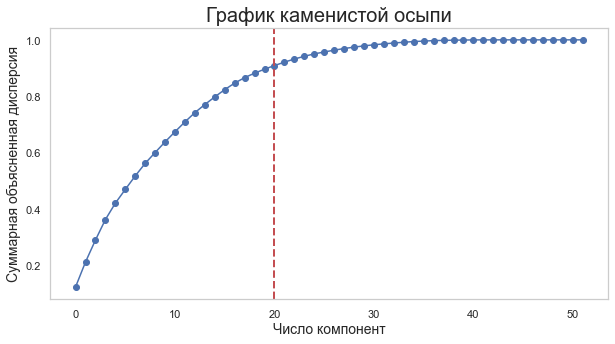

In [39]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_test.explained_variance_ratio_), marker='o')
plt.title('График каменистой осыпи', fontsize=20)
plt.xlabel('Число компонент', fontsize=14)
plt.ylabel('Суммарная объясненная дисперсия', fontsize=14)
plt.grid(b=None)
plt.axvline(linewidth=2, color='r', linestyle = '--', x=20, ymin=0, ymax=1)
plt.show()

Исходя из таблицы кумуляты доли объясненной дисперсии и графика каменистой осыпи, выберем в качестве числа главных компонент 20 главных компонент - поскольку, в таком случае процент потерянной информации составляет 10%, а процент сохраненной - 90%, что является стандартным результатом, а также график каменистой осыпи меняет коэффициент угла наклона в точке 20 резко на более низкий.

In [40]:
pca = PCA(n_components=20).fit(x)
x_fact = pd.DataFrame(pca.transform(x))

In [41]:
x_not_fact = x.copy()

In [42]:
x_fact

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1.377685,0.326622,-0.398818,0.251204,0.303880,-0.075217,-0.146258,0.097521,0.655493,-0.177491,-0.062470,-0.492971,-0.433063,0.036317,0.208518,-0.241419,-0.693121,0.170250,0.713487,-0.244013
1,-1.348558,0.366916,-0.183322,0.436043,0.071741,0.871835,-0.568952,0.355952,0.583973,-0.113972,-0.151250,-0.513011,-0.513521,0.077474,-0.005249,-0.556450,0.167957,-0.059142,0.182034,0.223960
2,-0.947928,-0.965880,0.042033,0.401264,0.064995,0.849134,-0.661371,0.326761,0.576435,-0.117773,-0.139711,-0.494160,-0.510843,0.080349,-0.033707,-0.566585,0.168706,-0.069921,0.154031,0.232742
3,-1.247277,0.419694,-0.029354,0.218130,0.674099,0.243998,-0.240980,-0.124252,0.544769,-0.186770,-0.087384,-0.515191,-0.644043,-0.164617,-0.128496,0.482682,-0.234380,0.242463,0.004566,0.393384
4,-1.318501,0.279333,-0.143139,0.410478,0.122300,1.385529,0.719152,0.594052,0.568317,-0.105599,-0.132429,-0.531852,-0.452922,0.052279,0.017790,-0.577374,0.186796,-0.058077,0.182641,0.217255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38240,0.804427,-0.553408,-0.757840,0.160102,0.131921,-0.158363,-0.301562,0.553191,0.202730,0.077326,0.038235,1.037068,0.276376,0.380835,-0.055522,0.300758,-0.082633,0.661887,0.567824,0.299875
38241,0.270002,0.700388,-1.173518,0.323868,-0.157446,-0.348287,-0.018218,0.146211,0.196907,0.060850,0.051909,1.039859,0.173941,0.116705,-0.135606,0.340796,-0.115874,0.838916,-0.165210,0.391921
38242,0.949999,-0.442553,-0.439206,0.032162,0.793756,-0.214652,-0.211646,-0.059867,0.202430,0.084300,0.060374,0.994931,0.266560,0.569677,-0.010513,-0.320447,0.082722,0.450193,0.223985,-0.140399
38243,0.426739,0.795151,-0.880653,0.116332,0.003190,-0.374348,-0.194722,1.106780,0.177010,0.054627,-0.034251,0.985268,0.140267,0.393538,-0.320520,0.464701,0.090030,0.720623,0.015505,-0.019236


In [43]:
x_not_fact

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,mar,may,nov,oct,sep,fri,mon,thu,tue,wed
0,0.481481,0.053070,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.493827,0.030297,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.246914,0.045954,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.283951,0.030704,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.481481,0.062424,0.000000,1.0,0.000000,0.937500,0.698753,0.60251,0.957379,0.859735,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38240,0.691358,0.067914,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38241,0.358025,0.077877,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38242,0.481481,0.038430,0.023810,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
38243,0.333333,0.089874,0.000000,1.0,0.000000,0.479167,1.000000,0.00000,0.089322,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 3) Использование random forest classifier на изначальных данных и на 20-ти главных компонентах

### Использование случайного леса без факторного анализа (без метода главных компонент)

Сперва заметим, что классы несбалансированны - поэтому в качестве криетрия качества выберем balanced_accuracy.

In [44]:
df['y'].value_counts()

0    33987
1     4258
Name: y, dtype: int64

In [45]:
x_simple_train, x_simple_test, y_simple_train, y_simple_test = train_test_split(x_not_fact, y, test_size=0.33, random_state = 1337) 

In [46]:
params_set_simple = {  
      'n_estimators': [100, 300],
      'max_depth': [8, 10],
      "min_samples_leaf": [3, 5],
      "min_samples_split": [3, 5],
      'bootstrap': [False, True]
}
model_simple = RandomForestClassifier(random_state=54,
                               criterion='gini',
                               min_impurity_decrease=0.0002)

model_simple_GS = GridSearchCV(
    model_simple,
    params_set_simple,
    cv=5,
    error_score='raise',
    scoring='balanced_accuracy')

In [47]:
model_simple_GS.fit(x_simple_train, y_simple_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0002,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=54,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap

In [60]:
probabilities_simple_GS = model_simple_GS.best_estimator_.predict_proba(x_simple_test)

In [90]:
print(f"Значение accuracy на обучающей выборке составило {np.round(accuracy_score(y_simple_train, model_simple_GS.best_estimator_.predict(x_simple_train))*100, 2)}%.")
print(f"Значение accuracy на тестовой выборке составило {np.round(accuracy_score(y_simple_test, model_simple_GS.best_estimator_.predict(x_simple_test))*100, 2)}%.")

Значение accuracy на обучающей выборке составило 90.81%.
Значение accuracy на тестовой выборке составило 90.35%.


In [91]:
print(f"Значение balanced_accuracy на обучающей выборке составило {np.round(balanced_accuracy_score(y_simple_train, model_simple_GS.best_estimator_.predict(x_simple_train))*100, 2)}%.")
print(f"Значение balanced_accuracy на тестовой выборке составило {np.round(balanced_accuracy_score(y_simple_test, model_simple_GS.best_estimator_.predict(x_simple_test))*100, 2)}%.")

Значение balanced_accuracy на обучающей выборке составило 60.75%.
Значение balanced_accuracy на тестовой выборке составило 60.8%.


In [89]:
print("Доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8, составила",
      f"{np.round(len(probabilities_simple_GS[probabilities_simple_GS > 0.8]) / len(probabilities_simple_GS), 2)}.")

Доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8, составила 0.83.


In [92]:
print(f"Значение balanced_accuracy на общей выборке составило {np.round(balanced_accuracy_score(y, model_simple_GS.best_estimator_.predict(x_not_fact))*100, 2)}%.")
print(f"Значение accuracy на общей выборке составило {np.round(accuracy_score(y, model_simple_GS.best_estimator_.predict(x_not_fact))*100, 2)}%.")

Значение balanced_accuracy на общей выборке составило 60.77%.
Значение accuracy на общей выборке составило 90.66%.


Таблица значимости факторов в задаче классификации random forest classifier без использования факторного анализа.

In [68]:
pd.DataFrame({'feature': df.iloc[:, :-1].columns,
              'importance': model_simple_GS.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
1,age,0.250445
9,euribor3m,0.200896
8,cons.conf.idx,0.184694
3,campaign,0.102979
5,previous,0.065657
6,emp.var.rate,0.047060
7,cons.price.idx,0.047035
4,pdays,0.018015
0,y,0.013698
42,jun,0.012740


Как видно, из 52 факторов всего порядка 20-ти факторов, которые имеют показатель importance больше 1% - остальные же 32 фактора имеют importance <1%, что свидетельствует о том, что необходим факторный анализ (либо построение модели на 20-ти самых "важных" факторах).

In [72]:
conf_mat_simple_GS = confusion_matrix(y_simple_test, model_simple_GS.best_estimator_.predict(x_simple_test))
conf_mat_simple_GS = pd.DataFrame(conf_mat_simple_GS, index=model_simple_GS.best_estimator_.classes_, columns=model_simple_GS.best_estimator_.classes_)
conf_mat_simple_GS

,0,1
0,11077,89
1,1129,326


In [71]:
print("Другие метрики качества модели, полученной без использования факторного анализа:\n")
print(classification_report(y_simple_test, model_simple_GS.best_estimator_.predict(x_simple_test)))

Другие метрики качества модели, полученной без использования факторного анализа:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11166
           1       0.79      0.22      0.35      1455

    accuracy                           0.90     12621
   macro avg       0.85      0.61      0.65     12621
weighted avg       0.89      0.90      0.88     12621



### Использование случайного леса c применением результатов факторного анализа (метода главных компонент)

In [62]:
x_fact_train, x_fact_test, y_fact_train, y_fact_test = train_test_split(x_fact, y, test_size=0.33, random_state = 1337) 

In [63]:
params_set_fact = {  
      'n_estimators': [100, 300],
      'max_depth': [8, 10],
      "min_samples_leaf": [3, 5],
      "min_samples_split": [3, 5],
      'bootstrap': [False, True]
}
model_fact = RandomForestClassifier(random_state=54,
                               criterion='gini',
                               min_impurity_decrease=0.0002)

model_fact_GS = GridSearchCV(
    model_fact,
    params_set_fact,
    cv=5,
    error_score='raise',
    scoring='balanced_accuracy')

In [64]:
model_fact_GS.fit(x_fact_train, y_fact_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0002,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=54,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap

In [65]:
probabilities_fact_GS = model_fact_GS.best_estimator_.predict_proba(x_fact_test)

In [83]:
print(f"Значение accuracy на обучающей выборке составило {np.round(accuracy_score(y_fact_train, model_fact_GS.best_estimator_.predict(x_fact_train))*100, 2)}%.")
print(f"Значение accuracy на тестовой выборке составило {np.round(accuracy_score(y_fact_test, model_fact_GS.best_estimator_.predict(x_fact_test))*100, 2)}%.")

Значение accuracy на обучающей выборке составило 89.81%.
Значение accuracy на тестовой выборке составило 88.59%.


In [84]:
print(f"Значение balanced_accuracy на обучающей выборке составило {np.round(balanced_accuracy_score(y_fact_train, model_fact_GS.best_estimator_.predict(x_fact_train))*100, 2)}%.")
print(f"Значение balanced_accuracy на тестовой выборке составило {np.round(balanced_accuracy_score(y_fact_test, model_fact_GS.best_estimator_.predict(x_fact_test))*100, 2)}%.")

Значение balanced_accuracy на обучающей выборке составило 53.77%.
Значение balanced_accuracy на тестовой выборке составило 51.83%.


In [82]:
print("Доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8, составила",
      f"{np.round(len(probabilities_fact_GS[probabilities_fact_GS > 0.8]) / len(probabilities_fact_GS), 2)}.")

Доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8, составила 0.86.


In [86]:
print(f"Значение balanced_accuracy на общей выборке составило {np.round(balanced_accuracy_score(y, model_fact_GS.best_estimator_.predict(x_fact))*100, 2)}%.")
print(f"Значение accuracy на общей выборке составило {np.round(accuracy_score(y, model_fact_GS.best_estimator_.predict(x_fact))*100, 2)}%.")

Значение balanced_accuracy на общей выборке составило 53.11%.
Значение accuracy на общей выборке составило 89.41%.


In [76]:
pd.DataFrame({'feature': x_fact.columns,
              'importance': model_fact_GS.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,0,0.243431
12,12,0.127184
3,3,0.093340
17,17,0.085268
1,1,0.075632
16,16,0.050941
8,8,0.044419
11,11,0.042547
19,19,0.034477
18,18,0.027686


Как видно, из 20-ти все факторы имеют показатель importance больше ~1%, что свидетельствует о том, что проведенный факторный анализ был выполнен не зря - все факторы оказались значимы.

In [77]:
conf_mat_fact_GS = confusion_matrix(y_fact_test, model_fact_GS.best_estimator_.predict(x_fact_test))
conf_mat_fact_GS = pd.DataFrame(conf_mat_fact_GS, index=model_fact_GS.best_estimator_.classes_, columns=model_fact_GS.best_estimator_.classes_)
conf_mat_fact_GS

,0,1
0,11122,44
1,1396,59


In [78]:
print("Другие метрики качества модели, полученной с использованием факторного анализа (метода главных компонент):\n")
print(classification_report(y_fact_test, model_fact_GS.best_estimator_.predict(x_fact_test)))

Другие метрики качества модели, полученной с использованием факторного анализа (метода главных компонент):

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11166
           1       0.57      0.04      0.08      1455

    accuracy                           0.89     12621
   macro avg       0.73      0.52      0.51     12621
weighted avg       0.85      0.89      0.84     12621



Вывод: таким образом, сравнивая результаты использования случайного леса для данных без применения метода главных компонент (далее PCA) и с применением PCA, мы имеем, что базовая random forest модель дала наилучшие результаты: на общей выборке её показатель accuracy составил 90.66%, а balanced_accuracy 60.77%, в то время как модель random forest с использованием PCA показала слудующие результаты: на общей выборке её показатель accuracy составил 89.41%, а balanced_accuracy 53.11%. Также стоит отметить, что без использования PCA из 52 факторов значимыми (с показателем importance >1%) оказались всего 20 факторов, в то время как с использованием PCA и снижением размерности с 52 факторов до 20, все факторы оказались значимыми. Из этого следует, что разница в качестве моделей объясняется снижением размерности с 52 факторов до 20 и потерей 10% объясненной дисперсии.

Данная лабораторная работа позволяет сделать важное наблюдение: бывает так, что модель классифицкации в которой используется PCA (или другой метод факторного анализа направленный на понижение размерности исходных данных) и широкомасштабная оптимизация гиперпараметров, может работать не так хорошо, как самая обыкновенная модель на стандартном наборе данных. Однако, это не аргумент для того, чтобы ограничивать себя лишь простейшими моделями - использование PCA вынуждает нас терять часть информации, соответственно, ожидается изначально, что показатели качества модели будут немного ниже, чем без использования PCA, но, с другой стороны, использование PCA позволяет значительно сократить размерность входных данных - а как результат, время вычислительной работы (например gridsearch'а) будет значительно меньше в случае применения PCA.